# Проектная работа: "Сборный проект —2"

## Вступление:

**Мы работаем в компании «Работа с заботой» в отеде HR-аналитика. К нам обратился заказчик с целью оптимизации управления персоналом. Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании "job_satisfaction_rate" - данные параметр принимает значения от 0 до 1 (показывает долю удовлетворенности работниками в организации). Нам предстоит выполнить несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании - бинарный параметр "quit".**

Признаковое описание для первой модели, где параметр "job_satisfaction_rate" - целевой признак:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Признаковое описание для второй модели тоже самое,  тольско значения параметра "job_satisfaction_rate" являются  предсказанными, параметр "quit" целевой:



 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание и план проекта. Молодец! Это поможет тебе расставлять акценты в выводах

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install shap -q 

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import stats as st 
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import phik 
from sklearn.inspection import permutation_importance

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, accuracy_score, make_scorer, f1_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,  plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.svm import SVC 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
import shap

import warnings 
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [2]:
data_job_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
data_test_features = pd.read_csv('/datasets/test_features.csv')
data_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
data_job_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [4]:
data_job_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
data_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [6]:
data_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
data_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [8]:
data_test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### При выгрузки данных обнаружили несколько пропусков, а точнее: у data_job_train в параметрах "dept" и "level" (10);  у data_test_features в тех же самых признаках "dept" и "level" (3)

### В целом признаковое описание соответствует документации - с данными можно работать дальше, устранив выявленные недочеты выше.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Полученная информация поможет нам в дальнейшем с предобработкой данных

## Шаг. Предобработка данных

### На этапе выгрузки и вывода общей информации о данных, мы увидели наличие пропусков, которые нужно устранить.

In [9]:
data_job_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [10]:
data_job_train[data_job_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [11]:
data_job_train[data_job_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [12]:
#### Так пропущенные значения находятся в категориальных параметрах, то заполнить их коректно не предоставляется возможным - просто удалим эти строки

In [13]:
#data_job_train = data_job_train.dropna().reset_index(drop=True)
#print(data_job_train.shape)
#data_job_train.isna().sum()

#### Не будем избавляться от пропущенных значений в data_job_train

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

In [14]:
data_test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [15]:
data_test_features[data_test_features['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [16]:
data_test_features[data_test_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [17]:
#data_test_features = data_test_features.dropna().reset_index(drop=True)
#print(data_test_features.shape)
#data_test_features.isna().sum()

### Проверим данные на наличие полных явных дубликатов:

In [18]:
data_job_train.duplicated().sum()

0

In [19]:
data_test_target.duplicated().sum()

0

In [20]:
data_test_target.duplicated().sum()

0

### Проверим данные на наличие неявных дубликатов, отобразив уникальные значения для каждого категориального столбца:

In [21]:
col_check1 = data_job_train.select_dtypes(exclude='number').columns
for column1 in data_job_train[col_check1].columns:
    print(column1, data_job_train[column1].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [22]:
col_check2 = data_test_features.select_dtypes(exclude='number').columns
for column2 in data_test_features[col_check2].columns:
    print(column2, data_test_features[column2].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [23]:
data_test_features['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [24]:
data_test_features['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

#### Обнаружились пропуски, обозначенные пробелами -  не удаляя строки, заменим их на значения nan.

In [25]:
#data_test_features = data_test_features.query('dept != " "')
#data_test_features = data_test_features.query('workload != " "')

#print(data_test_features['dept'].unique(), data_test_features['workload'].unique())

In [26]:
data_test_features['dept'] = data_test_features['dept'].replace(' ', np.nan)
data_test_features['workload'] = data_test_features['workload'].replace(' ', np.nan)

print(data_test_features['dept'].unique(), data_test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan] ['medium' 'low' 'high' nan]


In [27]:
### Избавились от пропусков в данных и проверили все датасеты на наличие явных и неявных дубликатов. Названия столбцов удовлетворяют стандарту "змеиного_регистра". Все значения соответствуют указанному типу данных при describe()

### Обработали все скрытые и явные пропуски. Названия столбцов удовлетворяют стандарту "змеиного_регистра". Все значения соответствуют указанному типу данных при describe()

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

## Шаг. Исследовательский анализ данных

In [28]:
data_job_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [29]:
data_test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [30]:
data_test_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


### Построим гистограммы для всех кол-венных признаков 

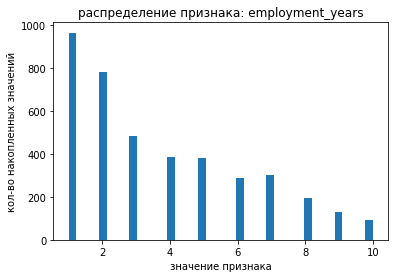

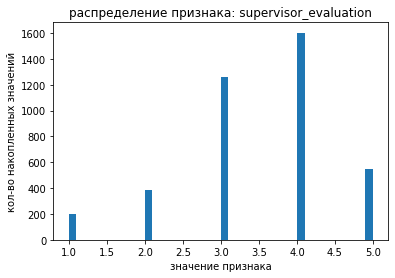

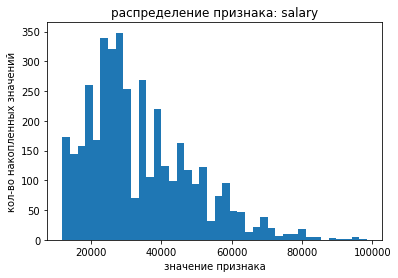

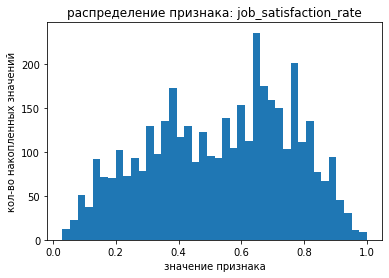

In [31]:
num_columns_train = data_job_train.select_dtypes(include='number').drop('id', axis=1).columns
for column_num1 in data_job_train[num_columns_train].columns:
    data_job_train[column_num1].plot(kind='hist', bins=40, title=f'распределение признака: {column_num1}')
    plt.xlabel('значение признака')
    plt.ylabel('кол-во накопленных значений')
    plt.show()

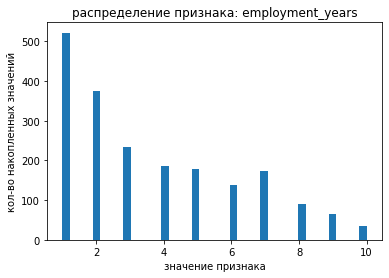

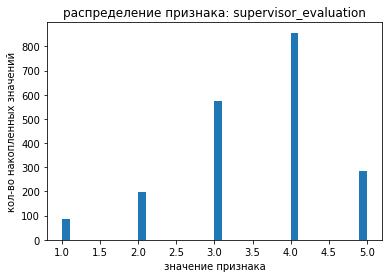

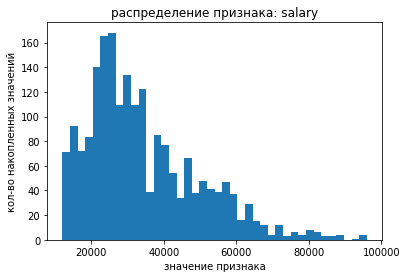

In [32]:
num_columns_train2 = data_test_features.select_dtypes(include='number').drop('id', axis=1).columns
for column_num2 in data_job_train[num_columns_train2].columns:
    data_test_features[column_num2].plot(kind='hist', bins=40, title=f'распределение признака: {column_num2}')
    plt.xlabel('значение признака')
    plt.ylabel('кол-во накопленных значений')
    plt.show()

### Для дискретных величин построим отдельные графики

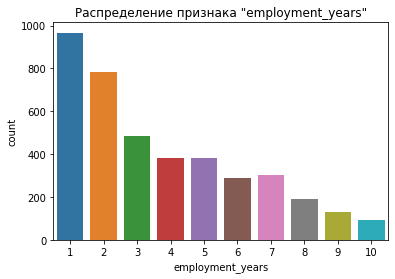

In [33]:
sns.countplot(data_job_train['employment_years']);
plt.title('Распределение признака "employment_years"');

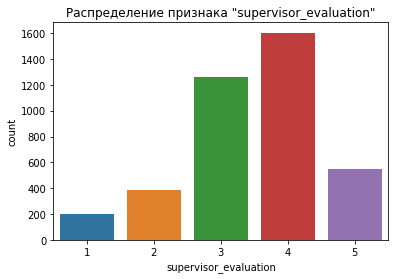

In [34]:
sns.countplot(data_job_train['supervisor_evaluation']);
plt.title('Распределение признака "supervisor_evaluation"');

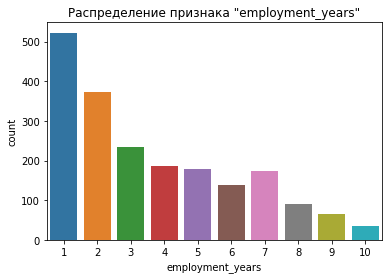

In [35]:
sns.countplot(data_test_features['employment_years']);
plt.title('Распределение признака "employment_years"');

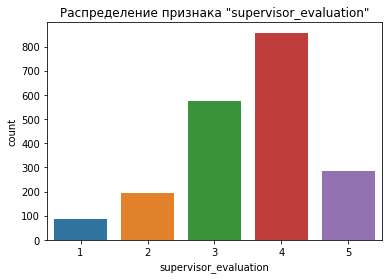

In [36]:
sns.countplot(data_test_features['supervisor_evaluation']);
plt.title('Распределение признака "supervisor_evaluation"');

### Построим boxplotы 

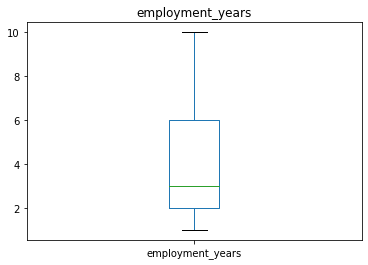

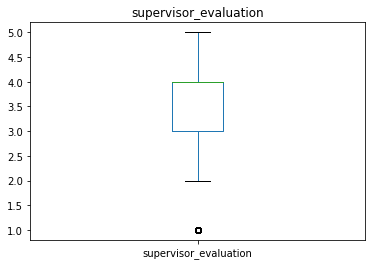

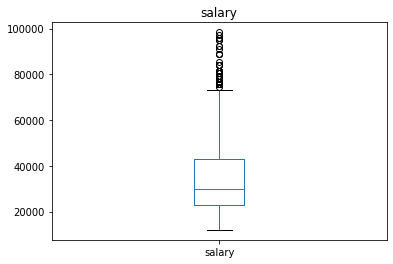

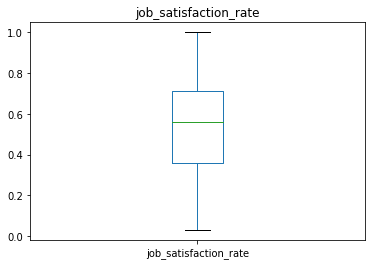

In [37]:
for column in num_columns_train:
    data_job_train[column].plot(kind='box', title=column)
    plt.show()

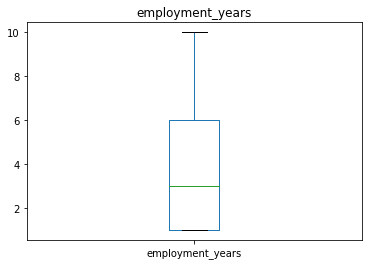

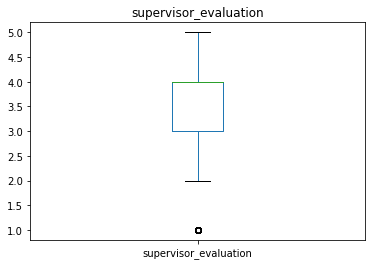

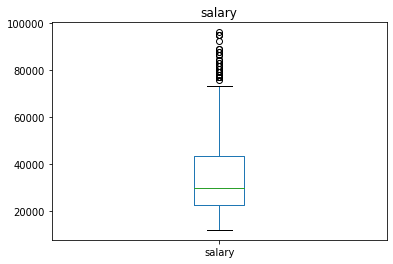

In [38]:
for column in num_columns_train2:
    data_test_features[column].plot(kind='box', title=column)
    plt.show()

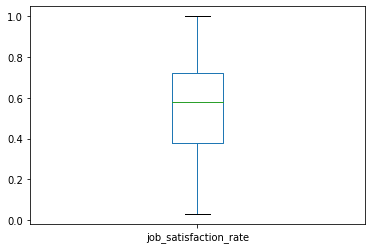

In [39]:
data_test_target['job_satisfaction_rate'].plot(kind='box');

### Построим графики рапсределения для категориальных признаков

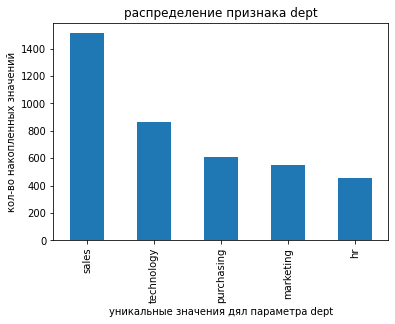

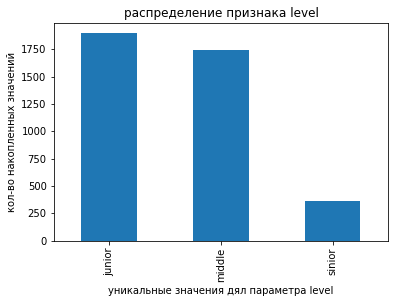

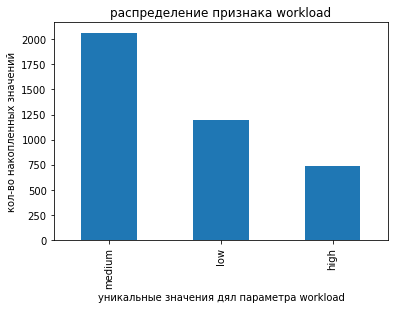

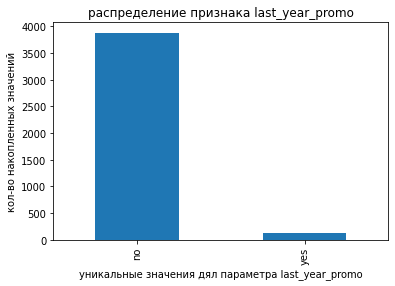

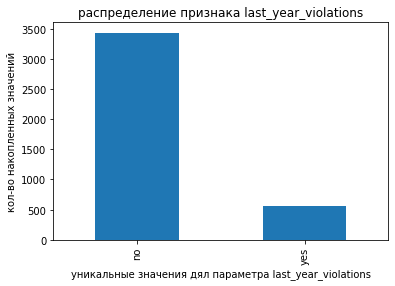

In [40]:
columns_categorical = data_job_train.select_dtypes(exclude='number').columns
for cat_column in data_job_train[columns_categorical].columns:
    data_job_train[cat_column].value_counts().plot(kind='bar', title=f'распределение признака {cat_column}')
    plt.xlabel(f'уникальные значения дял параметра {cat_column}')
    plt.ylabel('кол-во накопленных значений')
    plt.show()
    

### Построим попарные диаграммы рассеяния

In [41]:
data_for_cor = data_job_train.select_dtypes(exclude='number')
data_for_cor.columns

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

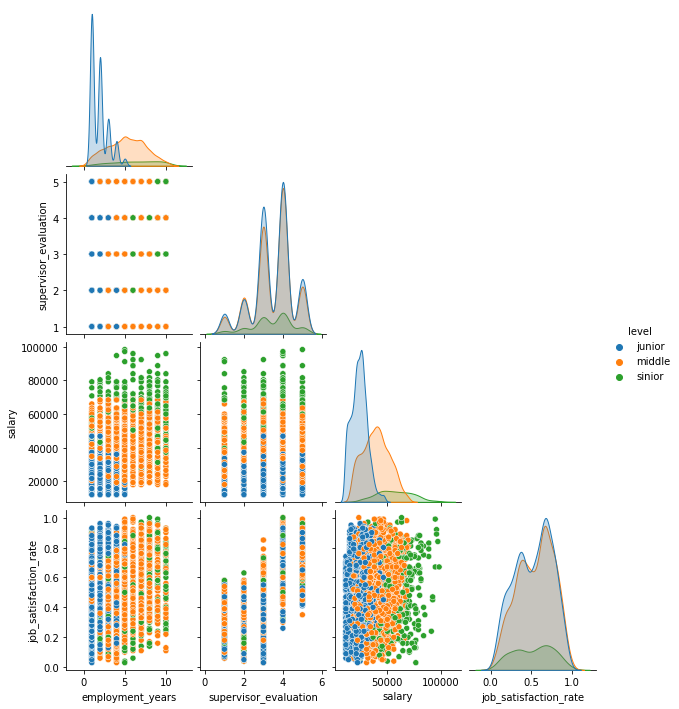

In [42]:
sns.pairplot(
    data=data_job_train.drop('id', axis=1),
    aspect=.85,
    hue='level',
    corner=True
);

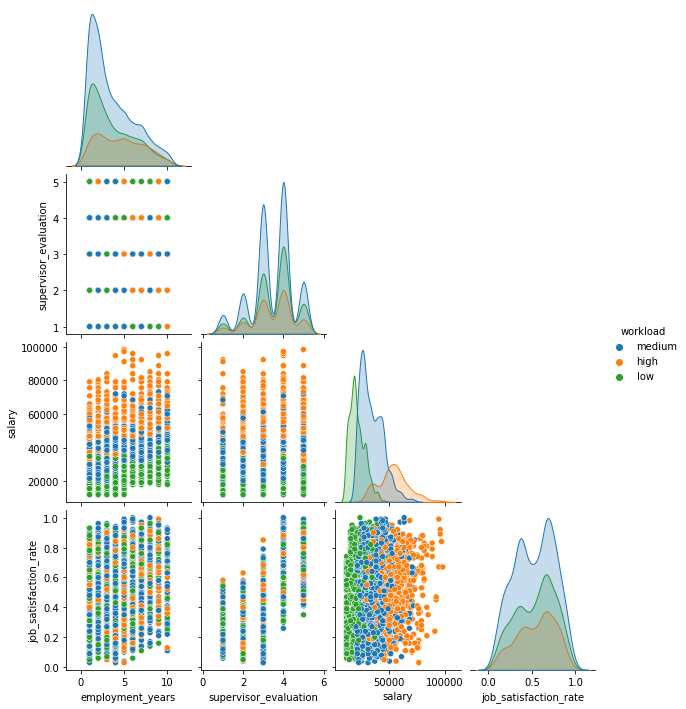

In [43]:
sns.pairplot(
    data=data_job_train.drop('id', axis=1),
    aspect=.85,
    hue='workload',
    corner=True
);

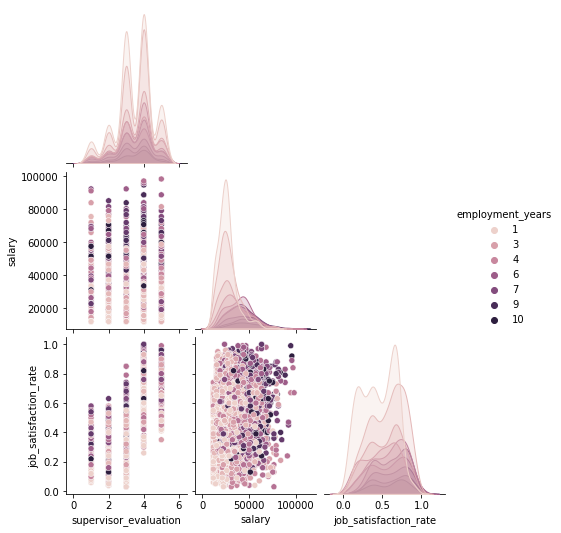

In [44]:
sns.pairplot(
    data=data_job_train.drop('id', axis=1),
    aspect=.85,
    hue='employment_years',
    corner=True
);

### Корреляционный анализ

In [45]:
data_job_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [46]:
interval_cols =  data_job_train.select_dtypes(include='number').drop('id', axis=1).columns
phik_overview = data_job_train.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

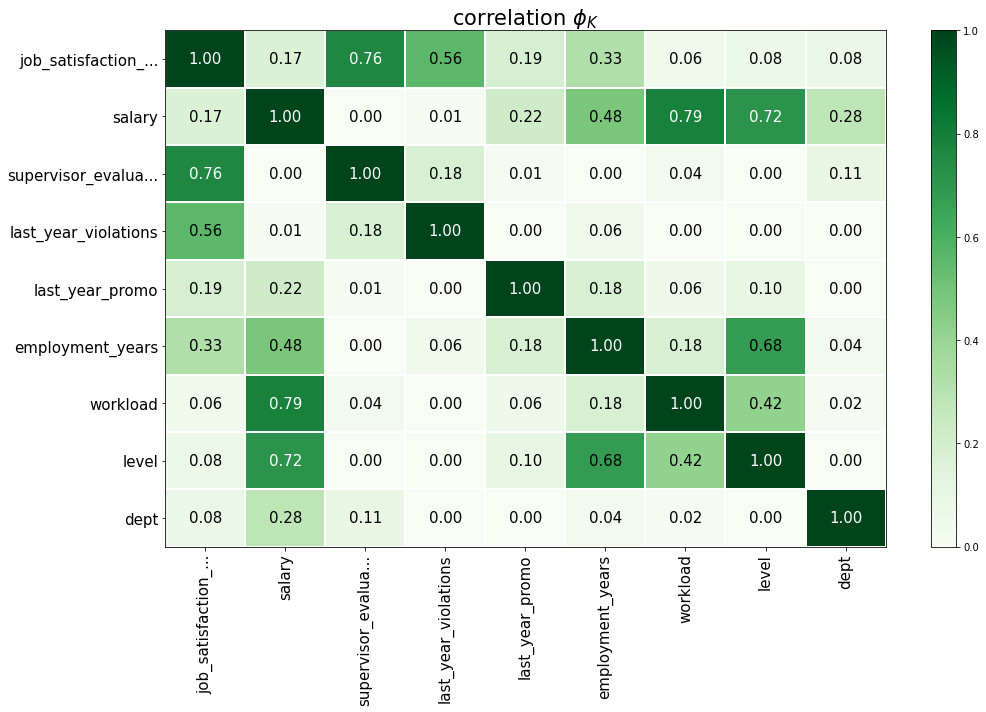

In [47]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Отлично, что при использовании phik настроен параметр interval_cols)

### Стат анализ итоги:
- построив гистограммы распределения и boxplot'ы, мы не обнаружили наличие аномалий и выбросов в данных, которые можно было удалить
- определили, что параметры "employment_years" и "supervisor_evaluation" имеют дискретную природу 
- показали распределение всех категориальных признаков 
- отобразили попарную корреляцию между всеми кол признаками - обнаружили, что признаки "employment_years" и "supervisor_evaluation" имеют с остальными параметрами характерную связь, которая свойственна кат признакам - можно отнести "employment_years" и "supervisor_evaluation" к кат. порядковым даннным.
- обнаружили такие закономерности: более высокую зарплатку получают ниболее загруженные работники, уровень занимаемой должности влияет на зарплату работника, оценка получаемая от руководителя и удовлетворенность работой взаимосвязаны между собой.
- утечки данных нет
- наиболее коррелирующие признаки с нашим таргетом: "employment_years", "last_year_violations", "job_satisfaction_rate"

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить проведенный исследовательский анализ данных, твои графики, осмысленный и красочный графический анализ. Найдены очень интересные закономерности)

## Шаг. Подготовка данных

###  Объединим данные data_test_features и data_test_target

In [48]:
data_test_features.shape

(2000, 9)

In [49]:
data_test_target.shape

(2000, 2)

In [50]:
data_job_test = data_test_features.merge(data_test_target, on='id', how='left')
data_job_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Хорошо, что объединение происходит по `id`

In [51]:
data_job_test.isna().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [52]:
data_job_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


### Так как наши данные уже размечаны и разбиты, то просто обозначим  входные и целевые признаки для тестовой и тренировочной выборок.

In [53]:
data_job_test = data_job_test.set_index('id')
data_job_train = data_job_train.set_index('id')

In [54]:
X_train = data_job_train.drop('job_satisfaction_rate', axis=1)
X_test = data_job_test.drop('job_satisfaction_rate', axis=1)
y_train = data_job_train['job_satisfaction_rate']
y_test = data_job_test['job_satisfaction_rate']

In [55]:
X_train.shape

(4000, 8)

In [56]:
y_train.shape

(4000,)

In [57]:
X_test.shape

(2000, 8)

In [58]:
y_test.shape

(2000,)

### Обозначим кол-венные признаки, категориальные с горячей и линейной кодировкой

In [59]:
data_job_train.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [60]:
print(data_job_train['level'].unique())
data_job_train['workload'].unique()

['junior' 'middle' 'sinior' nan]


array(['medium', 'high', 'low'], dtype=object)

In [61]:
ohe_encoder = ['dept', 'last_year_promo', 'last_year_violations']

ord_encoder = ['level', 'workload']

numeric_columns = ['employment_years', 'salary', 'supervisor_evaluation']

### Создадим пайплайны

In [62]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior' 'middle' 'sinior'],
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [63]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [64]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe_enc', ohe_pipe, ohe_encoder),
        ('ord_enc', ord_pipe, ord_encoder),
        ('num_scl', StandardScaler(), numeric_columns)
    ], 
    remainder='passthrough'
) 

#pipe_final = Pipeline([
    #('preprocessor', data_preprocessor),
    #('models', LinearRegression())
#])

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 


Отлично, что использовано более одного энкодера, взятого из готовой реализации библиотеки sklearn)

In [65]:
### Итоговый пайплайн для линейной регресси готов  - попробуем обучить модель лин рег

In [66]:
#pipe_final.fit(X_train, y_train)

In [67]:
#predictions_test = pipe_final.predict(X_test)
#predictions_train = pipe_final.predict(X_train)

<div class="alert alert-info"> <b> Cравнение моделей и оценку лучшей модели по целевой метрике произвел ниже. Засунул в общий пайплайн "param_distributions" лин рег и дерево решенйи и отобразил лучшую результат целевой метрик с параметрами наилучшей модели </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

In [68]:
#model_coef = pipe_final['models'].coef_
#model_coef

### Для провекри качетсва модеди создадим собственную метрику SMAPE

In [69]:
def smape(true, pred):
    new_score = (abs(np.array(true).flatten() - np.array(pred)) / (
    abs(np.array(true).flatten() + np.array(pred)) / 2)).sum() * 100 / len(np.array(pred))
    return new_score

In [70]:
#### Оценим качесвто обученной модели

In [71]:
#smape_train = smape(y_train, predictions_train)
#smape_train

In [72]:
#smape_test = smape(y_test, predictions_test)
#smape_test

In [73]:
#### Значение sample на тестовой выборке (25.9) оказалось выше, чем пороговое значение (<=15) 

###  Воспользуемся моделью DecisionTree при кросс-валидации, подобрав оптимальные гиперпараметры, которые смогут удовлетворить наше пороговое значение метрики

In [74]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor())
    ]
)

### Зададим распределение гиперпараметров наших моделей  для CV

In [75]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 30),
        'models__min_samples_leaf' : range(2, 30)
    },
    
    {
        'models': [LinearRegression()]
   
    }
]

In [76]:
smape_cv = make_scorer(smape, greater_is_better=False)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Верно, что задаешь параметр `greater_is_better=False`. Дело в том, что разработчики пакета `sklearn` при создании функций `cross_val_score` и `GridSearchCV` утвердили соглашение: возвращаемые результаты вычислений данных функций должны соответствовать задаче максимизации (чем большее значение метрики получаем, тем лучше). При этом обратная задача минимизации может быть осуществлена через максимизацию метрики, домноженной на -1. Об этом можно чуть подробнее почитать в документации пакета, правда она на английском. Оставлю <a href = 'https://scikit-learn.org/stable/modules/model_evaluation.html'>ссылку</a>. 

In [77]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=20, 
    scoring=smape_cv
)

In [78]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe_enc',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord_enc',
                                                                               Pipelin...
                                                                                'supervisor_evaluation'])])),
                                             ('models',
                                              DecisionTreeRegressor())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(max_depth=20,
                                                                          min_samples_leaf=4,
                                                                          random_state=42)],
                                         'models__max_depth': range(2, 30),
                                         'models__min_samples_leaf': range(2, 30)},
                                        {'models': [LinearRegression()]}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [79]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_enc',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord_enc',
                                                  Pipeline(steps=[('simpleImputer_befo...
                                                                   OrdinalEncoder(categories=[['juniormiddlesinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num_scl', StandardScaler(),
                                                  ['employment_years', 'salary',
                                                   'supervisor_evaluation'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=20, min_samples_leaf=4,
                                       random_state=42))])

In [80]:
pred_1 = randomized_search.best_estimator_.predict(X_test)
smape(y_test, pred_1)

14.81192177341291

In [81]:
randomized_search.best_params_

{'models__min_samples_leaf': 4,
 'models__max_depth': 20,
 'models': DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, random_state=42)}

### На тестовой выборке модел дерева решений (DecisionTreeRegressor)  с гиперпараметрами (max_depth=20, min_samples_leaf=4, random_state=42) выдала метрику  SMAPE=14.81, что удовлетворяет нашему условию (smape<=15)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Тестирование лучшей модели проведено

## №2 Задача: предсказание увольнения сотрудника из компании

### Импортируем датасет с целевым признаком и возьмем прежнее признаковое описание с прошлого этапа

In [82]:
data_train_quit = pd.read_csv('/datasets/train_quit.csv')
data_test_features_quit = pd.read_csv('/datasets/test_features.csv')
data_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [83]:
data_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [84]:
data_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [85]:
data_test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [86]:
data_test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [87]:
data_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [88]:
data_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


### Данные соответствуют документации

### Предобработка данных 

In [89]:
data_test_features_quit.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [90]:
#data_test_features_quit = data_test_features_quit.dropna()
#data_test_features_quit.isna().sum()

<div class="alert alert-info"> <b> Пропуски оставил - неявные пропуски, выраженные пробелами, заменил на значения nan.np, обработка пропусков происходит в pipline предобработки </div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера 2 <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>

Любые пропуски в любых выборках нужно обрабатывать только готовыми реализованными инструментами библиотек (просто удалять или заполнять пропуски отдельными действиями или функцией без метода fit transform - нельзя) 

In [91]:
cat_columns = data_test_features_quit.select_dtypes(exclude='number').columns
for column in data_test_features_quit[cat_columns]:
    print(column, data_test_features_quit[column].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [92]:
data_test_features_quit['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [93]:
data_test_features_quit['workload'].value_counts()

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [94]:
data_test_features_quit['workload'] = data_test_features_quit['workload'].replace(' ', np.nan)
data_test_features_quit['dept'] = data_test_features_quit['dept'].replace(' ', np.nan)

In [95]:
#data_test_features_quit = data_test_features_quit.query('workload != " " and dept != " "')

In [96]:
data_test_features_quit['dept'].value_counts()

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

In [97]:
data_test_features_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [98]:
data_test_features_quit['workload'].value_counts()

medium    1043
low        593
high       363
Name: workload, dtype: int64

In [99]:
data_test_features_quit['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [100]:
cat_columns = data_train_quit.select_dtypes(exclude='number').columns
for column in data_train_quit[cat_columns]:
    print(column, data_train_quit[column].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [101]:
data_test_target_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

### Шаг 3. Исследовательский анализ данных

In [102]:
data_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [103]:
data_test_features_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


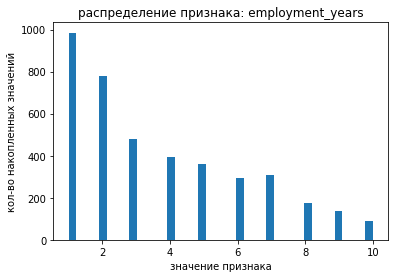

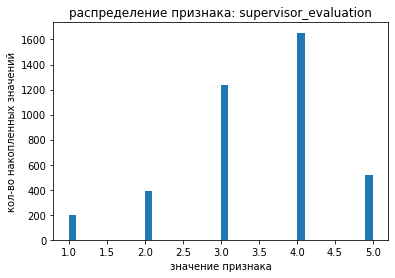

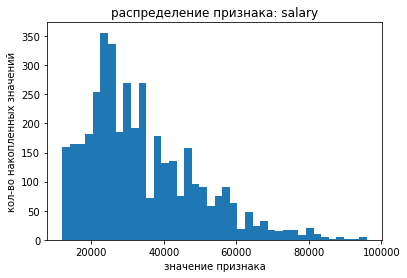

In [104]:
num_columns_train_quit = data_train_quit.select_dtypes(include='number').drop('id', axis=1).columns
for column_num in data_train_quit[num_columns_train_quit].columns:
    data_train_quit[column_num].plot(kind='hist', bins=40, title=f'распределение признака: {column_num}')
    plt.xlabel('значение признака')
    plt.ylabel('кол-во накопленных значений')
    plt.show()

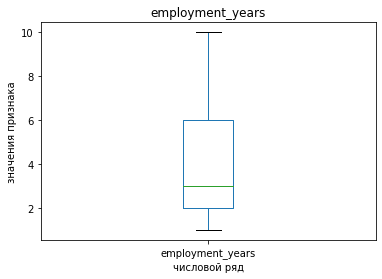

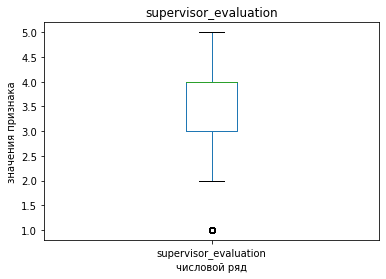

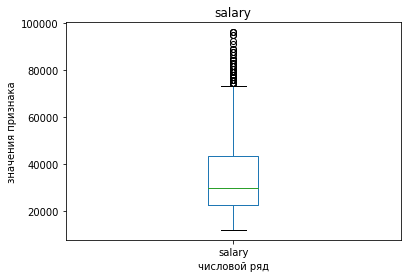

In [105]:
for column_num in data_train_quit[num_columns_train_quit].columns:
    data_train_quit[column_num].plot(kind='box',  title=f'{column_num}')
    plt.xlabel('числовой ряд')
    plt.ylabel('значения признака')
    plt.show()

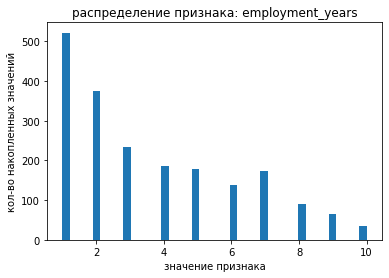

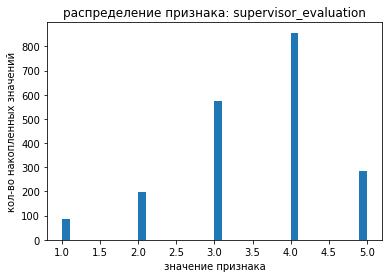

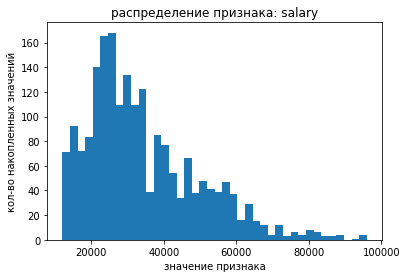

In [106]:
num_columns_train_quit_1 = data_test_features_quit.select_dtypes(include='number').drop('id', axis=1).columns
for column_num in data_test_features_quit[num_columns_train_quit_1].columns:
    data_test_features_quit[column_num].plot(kind='hist', bins=40, title=f'распределение признака: {column_num}')
    plt.xlabel('значение признака')
    plt.ylabel('кол-во накопленных значений')
    plt.show()

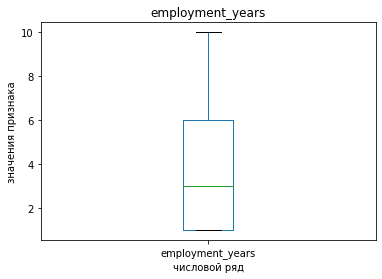

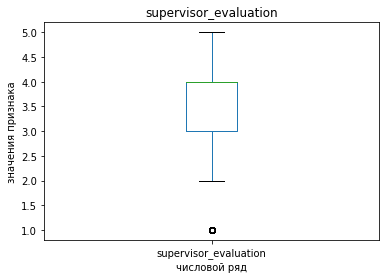

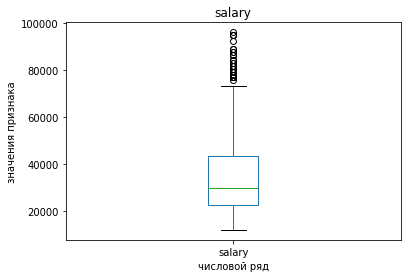

In [107]:
for column_num in data_test_features_quit[num_columns_train_quit].columns:
    data_test_features_quit[column_num].plot(kind='box',  title=f'{column_num}')
    plt.xlabel('числовой ряд')
    plt.ylabel('значения признака')
    plt.show()

### Распределение качественных признаков 

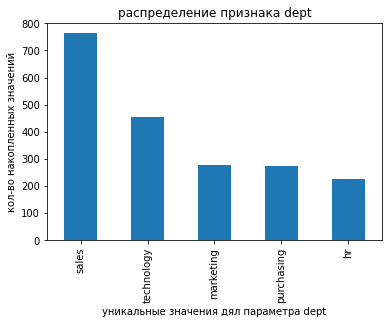

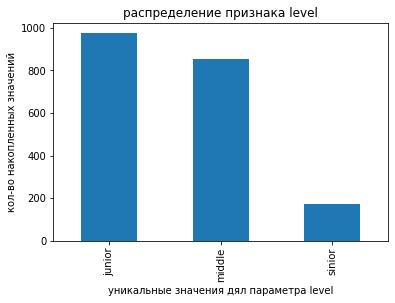

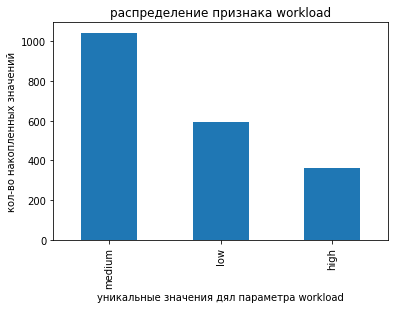

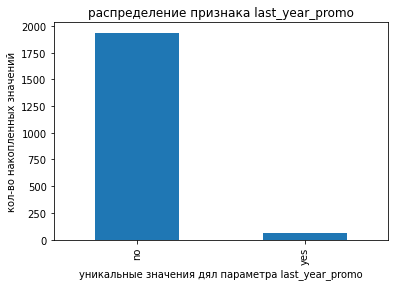

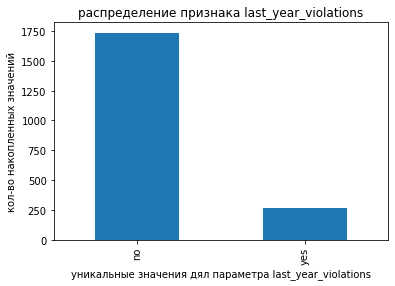

In [108]:
columns_categorical_quit  = data_test_features_quit.select_dtypes(exclude='number').columns
for cat_column in data_test_features_quit[columns_categorical].columns:
    data_test_features_quit[cat_column].value_counts().plot(kind='bar', title=f'распределение признака {cat_column}')
    plt.xlabel(f'уникальные значения дял параметра {cat_column}')
    plt.ylabel('кол-во накопленных значений')
    plt.show()
    

### Построим корреляционную матрицу 

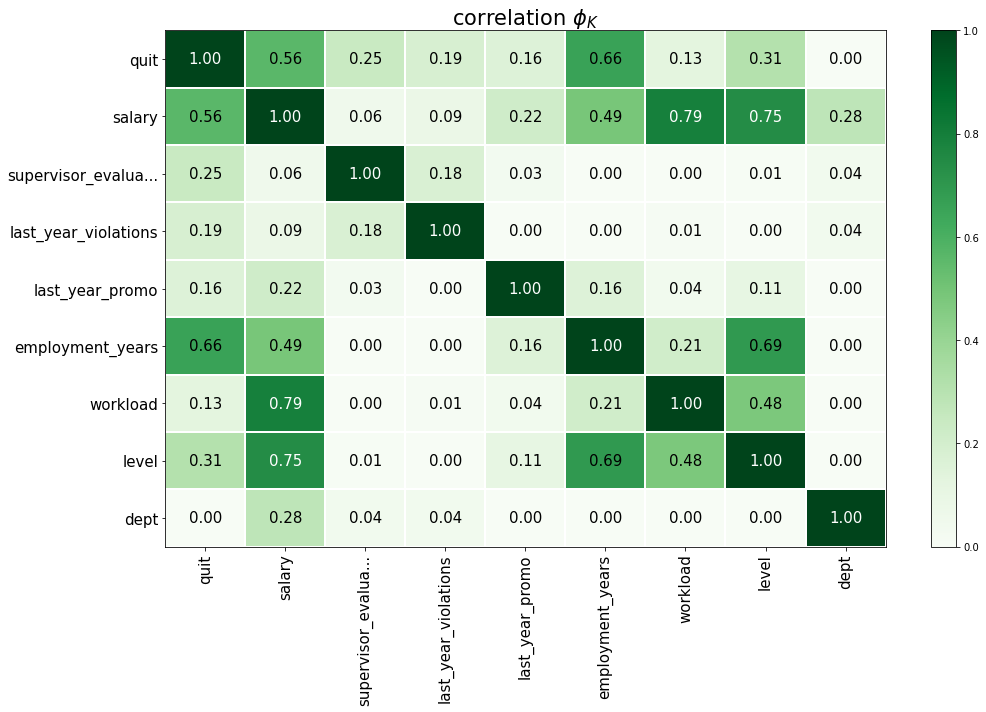

In [109]:
phik_overview = data_train_quit.drop('id', axis=1).phik_matrix(interval_cols=num_columns_train_quit)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

### Построим попарную диаграмму рассеяиния с учетом нового целевого признака

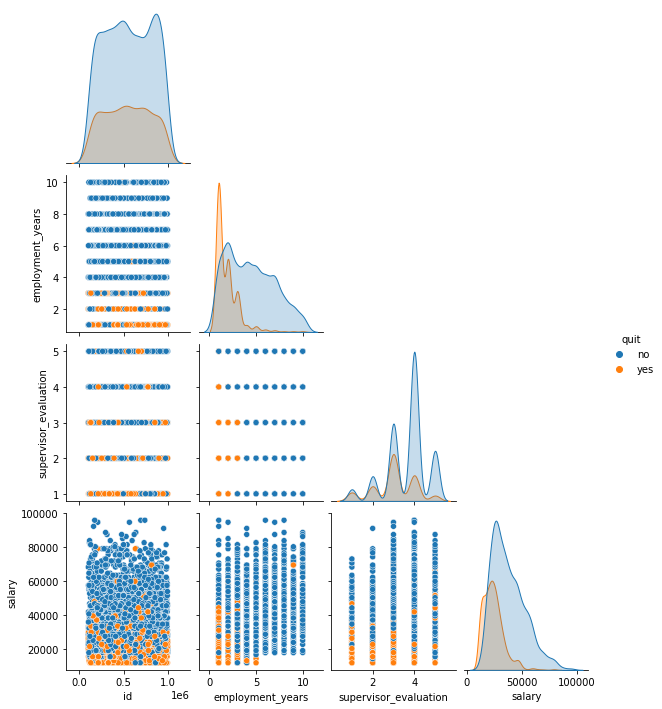

In [110]:
sns.pairplot(
    data=data_train_quit,
    aspect=.85,
    hue='quit',
    corner=True
);

In [111]:
data_train_quit.query('employment_years < 2').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('employment_years < 2').index))['employment_years']

quit
no     0.391878
yes    0.608122
All    1.000000
Name: employment_years, dtype: float64

#### Можно заметить, что к увольнению склонны больше половина работников (60%) , продолжительность работы в компании которых менее 2 лет

In [112]:
data_train_quit.query('salary < 25000').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('salary < 25000').index))['salary']

quit
no     0.471875
yes    0.528125
All    1.000000
Name: salary, dtype: float64

#### Половина работников, заработная плата которых меньше 25000 склонны к увольнению

In [113]:
data_train_quit.query('level == "sinior"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('level == "sinior"').index))['level']

quit
no     0.952381
yes    0.047619
All    1.000000
Name: level, dtype: float64

In [114]:
data_train_quit.query('level == "middle"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('level == "middle"').index))['level']

quit
no     0.936246
yes    0.063754
All    1.000000
Name: level, dtype: float64

In [115]:
data_train_quit.query('level == "junior"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('level == "junior"').index))['level']

quit
no     0.485377
yes    0.514623
All    1.000000
Name: level, dtype: float64

#### Для работников класса "junior" вероятность увольнения составляет 51%

In [116]:
data_train_quit.query('supervisor_evaluation <= 3 ').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('supervisor_evaluation <= 3').index))['supervisor_evaluation']

quit
no     0.571742
yes    0.428258
All    1.000000
Name: supervisor_evaluation, dtype: float64

In [117]:
data_train_quit.query('supervisor_evaluation <= 2 ').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('supervisor_evaluation <= 2').index))['supervisor_evaluation']

quit
no     0.563238
yes    0.436762
All    1.000000
Name: supervisor_evaluation, dtype: float64

In [118]:
data_train_quit.query('supervisor_evaluation <= 1').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('supervisor_evaluation <= 1').index))['supervisor_evaluation']

quit
no     0.529703
yes    0.470297
All    1.000000
Name: supervisor_evaluation, dtype: float64

#### Работники, получивших от руководителя оценку 1,  в 43% случаях увольняются (при уменьшении оценки, увеличивается доля уволившихся)

In [119]:
data_train_quit.query('workload == "low"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('workload == "low"').index))['workload']

quit
no     0.570364
yes    0.429636
All    1.000000
Name: workload, dtype: float64

In [120]:
data_train_quit.query('workload == "high"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('workload == "high"').index))['workload']

quit
no     0.820475
yes    0.179525
All    1.000000
Name: workload, dtype: float64

In [121]:
data_train_quit.query('workload == "medium"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('workload == "medium"').index))['workload']

quit
no     0.769594
yes    0.230406
All    1.000000
Name: workload, dtype: float64

#### У работников с низкой загруженностью самая высокая доля увольнений - 42% 

In [122]:
data_train_quit.query('last_year_promo=="yes"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('last_year_promo=="yes"').index))['last_year_promo']

quit
no     0.99115
yes    0.00885
All    1.00000
Name: last_year_promo, dtype: float64

In [123]:
data_train_quit.query('last_year_promo=="no"').pivot_table(index='quit', aggfunc=len, margins=True).div(
    len(data_train_quit.query('last_year_promo=="no"').index))['last_year_promo']

quit
no     0.710059
yes    0.289941
All    1.000000
Name: last_year_promo, dtype: float64

#### Работники  без повышений в прошлом году увольняются охотнее 28,9 % напротив 0.8% с повышением

In [124]:
dept_pivot = data_train_quit.pivot_table(index='quit', columns='dept', values='id', aggfunc='count', margins=True)
dept_pivot 

dept,hr,marketing,purchasing,sales,technology,All
quit,,,,,,
no,348,419,422,1031,652,2872
yes,116,163,166,407,276,1128
All,464,582,588,1438,928,4000


In [125]:
dept_pivot = data_train_quit.pivot_table(index='quit', columns='dept', values='id', aggfunc='count')
dept_pivot / dept_pivot.sum() * 100

dept,hr,marketing,purchasing,sales,technology
quit,,,,,
no,75.0,71.993127,71.768707,71.696801,70.258621
yes,25.0,28.006873,28.231293,28.303199,29.741379


<div class="alert alert-info"> <b> Различия в отношении между уволившимися и оставшимися сотрудниками в различных отделах несущественные. На общем фоне выделяется департамент "hr", доля уволившихся которого составляет 25%, что является самым низким показателем среди всех отделов. Остальные дирекции находятся примерно на одном том-же уровне. </div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

- HR осталось 348 (75%), ушло 116 (25%)
- MARKETING осталось 419 (71.99%), ушло 163 (28%)
- PURCHASING осталось 422 (71.76%), ушло 166 (28.23%)
- SALES осталось 1031 (71.69%), ушло 407 (28.3%)
- TECHNOLOGY осталось 652 (70.25%), ушло 276 (29.74%) 

#### Узнаем как удовлетворённость работников влияет на их увольнение 

In [126]:
data_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [127]:
data_test_target_quit = data_test_target_quit.set_index('id')

In [128]:
data_fusion = data_job_test.join(data_test_target_quit, how='left')

In [129]:
data_fusion.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


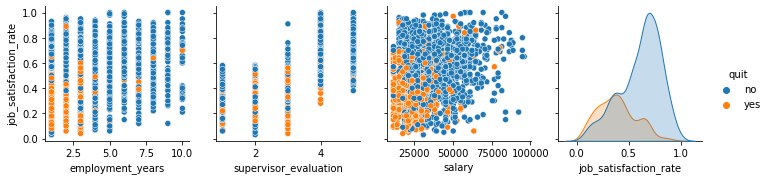

In [130]:
sns.pairplot(
    data=data_fusion, 
    hue='quit', 
    y_vars='job_satisfaction_rate')

In [131]:
data_fusion.pivot_table(index='quit', values='job_satisfaction_rate', aggfunc=['mean', 'median'])

,mean,median
,job_satisfaction_rate,job_satisfaction_rate
quit,,
no,0.612040,0.66
yes,0.387713,0.37


#### Средняя и медианная оценка удовлетворенности у уволившихся сотрудников ниже, чем у тех, кто продолжает работать, что можно заметить на графике распределения "job_satidfaction_rate" с учетом разбиения значений по кат признаку "quit" 

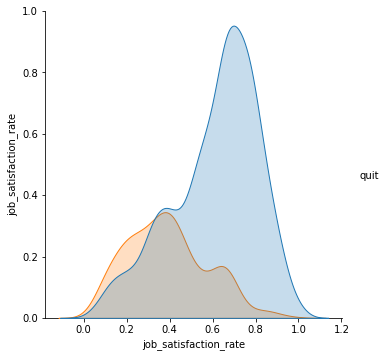

In [132]:
sns.pairplot(data=data_fusion[['quit', 'job_satisfaction_rate']], hue='quit', height=5)
plt.show()        

### Предсказание и добавление признака 'job_satisfaction_rate'

In [133]:
data_stf_for_pred = data_train_quit.drop('quit', axis=1).set_index('id')
data_stf_for_pred.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200


In [134]:
data_train_quit['job_satisfaction_rate'] = randomized_search.predict(data_stf_for_pred)
data_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.617500
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.332500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.331667
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошо, признак job_satisfaction_rate добавлен в тренировочную и тестовую выборки, а значения предсказаны с помощью лучшей модели регрессии, обученной в прошлой части задачи

### Подготовка данных 

- Разметка

In [135]:
data_train_quit = data_train_quit.set_index('id')

In [136]:
data_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.617500
814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.332500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.331667
910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [137]:
data_fusion.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [138]:
X_train = data_train_quit.drop('quit', axis=1)
y_train = data_train_quit['quit']
X_test = data_fusion.drop('quit', axis=1)
y_test = data_fusion['quit']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4000, 9) (4000,) (2000, 9) (2000,)


In [139]:
pd.DataFrame(X_train).columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

- Обозначение кол-венных и катеориальных переменных

In [140]:
ord_columns = ['level', 'workload']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
numeric_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

- создание "конвеера"

In [141]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [142]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior' 'middle' 'sinior'],
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [143]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), numeric_columns)
    ], 
    remainder='passthrough'
) 

In [144]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [145]:
param_grid = [
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15)
    },
    
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),   
        
    },

  
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 15)
    }
]


In [146]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика "roc_auc" лучшей модели:', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [147]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.023392,0.000235,0.009585,0.000189,12,7,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 12, 'models__max_dept...",0.911447,0.925299,0.907781,0.916573,0.939367,0.920093,0.011290,1
5,0.032007,0.003594,0.010434,0.000680,NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",4,NaN,"{'models__C': 4, 'models': LogisticRegression(...",0.920750,0.908015,0.920138,0.911732,0.922489,0.916625,0.005689,2
7,0.021772,0.001113,0.009808,0.000263,5,6,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 5, 'models__max_depth...",0.896900,0.916155,0.900920,0.905935,0.931165,0.910215,0.012298,3
6,0.022058,0.000602,0.009845,0.000246,6,7,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 6, 'models__max_depth...",0.885523,0.907942,0.898735,0.908722,0.932395,0.906663,0.015348,4
0,0.028867,0.005908,0.010278,0.000343,11,12,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 11, 'models__max_dept...",0.888151,0.923644,0.871018,0.860238,0.910992,0.890809,0.023744,5
1,0.026929,0.001564,0.010891,0.001033,11,10,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 11, 'models__max_dept...",0.891227,0.913596,0.875281,0.854734,0.917498,0.890467,0.023553,6
4,0.025334,0.000975,0.010190,0.000483,13,13,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 13, 'models__max_dept...",0.888487,0.912043,0.861988,0.859001,0.915286,0.887361,0.023826,7
9,0.023020,0.001012,0.016444,0.000365,NaN,NaN,KNeighborsClassifier(),NaN,2,"{'models__n_neighbors': 2, 'models': KNeighbor...",0.869523,0.889612,0.881078,0.867565,0.890182,0.879592,0.009600,8
8,0.022172,0.000763,0.009744,0.000218,7,3,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 7, 'models__max_depth...",0.870466,0.874218,0.863499,0.848062,0.883526,0.867954,0.011862,9
2,0.022665,0.003320,0.009914,0.000728,5,3,"DecisionTreeClassifier(max_depth=7, max_featur...",NaN,NaN,"{'models__max_features': 5, 'models__max_depth...",0.840792,0.817654,0.828521,0.823259,0.837285,0.829502,0.008583,10


In [148]:
proba_predicted = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, proba_predicted)}')

Метрика ROC-AUC на тестовой выборке: 0.9190422568600723


#### Обнаружили лучшую модель:  DecisionTreeClassifier(max_depth=7, max_features=12, random_state=42), ее метрика ROC_AUC score показала значение 92%, что выше порогового (91%)

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

 # Итог:

**Во время выполнения проекта мы затронули пять основных этапов работы с данными**
- Выгрузка данных 
- Предобработка данных 
- Исследовательский анализ данных 
- Подготовка данных к обучению 
- Обучения лучшей модели и прогноз целевых параметров

**1)На этапе предобработки данных мы в нескольких параметрах обнаружили скрытые пропуски " ", которые были успешно обработаны**

**2) На этапе "исследовательский анализ данных" мы отобразили распределение кат и кол признаков, построили для них гистограммы и столбчатые диаграммы по накопленным значениям - провели описательную статистику. Сделали корреляционный анализ, построив матрицу корреляции и попарные диаграммы рассеяния. Выявили наиболее значимые параметры для предсказания целевых признаков. Проверили параметры на наличие выброса в данных и мультиколлинеарности**

**3)Для подготовки данных мы использовали пайплайны, отмасштабировав количественные и закодировав категориальные признаки и перебрав различные параметры с их гиперпараметрами.**

**4) При помощи попарной диаграммы рассеяния с учетом категориального целевого признака "quit" по значениям мы можем составить приблизительный портрет работника, который вероятнее всего уволится из компании**

- Заработная плата меньше 25000 (52% увольнения)
- Продолжительность работы в компании менне двух лет (60.8%) 
- Работник занимает позицию Junior (51%)
- Он имеет низкую загруженность по работе (42%)
- Такой работник получает от своего руководителя оценку 1 (47%)
- А средняя и медианная оценка степени его удовлетворенности работой  ниже, чем у тех, кто не уволился 


**Задача всего проекта заключалась в том, чтобы помочь нашему клиенту оптимизировать управление сотрудниками в компанни. При помощи предоставленных данных - набора признакового описания мы построили две предиктивные модели.
Первая модель была создана для предсказания удовлетворенности сотрудников 'job_satisfaction_rate'. В ходе подбора гиперпараметров при помощи пайплайнов и метода RandomizedSearchCV лучшей моделью стала модель DecisionTreeRegressor с гиперпараметрами (max_depth=23, min_samples_leaf=4, random_state=42). Она выдала метрику SMAPE=14.81, что удовлетворило нашему условию (smape<=15). Для второй модели мы также провели предобработку и подготовку данных для , дали описательную статистику имеющимся признакам, добавив предсказанный первой моделью параметр 'job_satisfaction_rate'. Для подбора лучшего решения использовали как минимум три модели с перебором их гиперпараметров. Наилучшая модель стала - DecisionTreeClassifier(max_depth=7, max_features=12, random_state=42), ее метрика ROC_AUC score показала значение 92,37%, что выше требуемой границы (91%). В итоге, мы построили две модели, удовлетворяющие требования заказчика**

<div class="alert alert-info"> <b> Рекомендации заказчику: рекомендуем нашему клиенту воспользоваться двумя моделями МО, которые мы создали и качество которых было проверено на соответствующих метриках качества. Так же стоит обратить внимание на портрет сотрудника, который скорее всего может уволится.</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

- Работник проработал в компании менее двух лет
- Уровень его загруженности низкий 
- Он занимает позицию "junior"
- Оценка, полученная от руководителя, ниже двух
- Удовлетворенность работой ниже среднего 
- И заработная плата меньше 20-25 тыс.
- Повышения в прошлом году не было (
- Различие между отделами несущественная 

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера (общий вывод по проекту) <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии/ классификации и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использованы пайплайны, кросс-валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>